In [1]:
using ColoringNames
using CSVFiles
using DataFrames
#Plots.gr()

INFO: Recompiling stale cache file /home/wheel/oxinabox/.julia/lib/v0.6/DataDeps.ji for module DataDeps.


In [2]:
runnum = "7"
function mklogdir(name)
    logdir = joinpath(pwd(), "logs", "dist", name * runnum)
    mkpath(logdir)
    logdir
end

mklogdir (generic function with 1 method)

In [3]:
show_demo=false
function qualitative_demo(mdl, do_oov=true)
    if show_demo
        plot_query(mdl,  "brownish green") |> display
        plot_query(mdl,  "brown") |> display
        plot_query(mdl,  "brownish") |> display
        plot_query(mdl,  "greenish") |> display
        plot_query(mdl,  "greenish brown") |> display
        plot_query(mdl,  "green")|> display
        
        plot_query(mdl,  "bluish grey")|> display
        plot_query(mdl,  "greyish blue")|> display
        #plot_query(mdl, "pink-purple") |> display
        #plot_query(mdl, "purple-pink") |> display
        #plot_query(mdl, "brown-orange") |> display
        #plot_query(mdl, "orange-brown") |> display
        #plot_query(mdl, "orange-yellow") |> display
        #plot_query(mdl, "yellow-orange") |> display
        
        do_oov && plot_query(mdl,  "ish")|> display
    else
        info("showing demo disabled, set `show_demo=true` to display")
    end
end

qualitative_demo(mdl::TermToColorDistributionEmpirical) = qualitative_demo(mdl, false)

qualitative_demo (generic function with 3 methods)

In [4]:
const many_names = load_color_nameset()
const word_embs, vocab, enc = load_text_embeddings(keep_words=many_names)
const full_data = load_munroe_data(dev_as_train=false, dev_as_test=true, encoding_ = enc)

const ord_data = order_relevant_dataset(full_data);
const extrapo_data = extrapolation_dataset(full_data);

In [5]:
create_res_df() = DataFrame(method=String[], 
    perp=Float64[],
    perp_hue=Float64[],
    perp_sat=Float64[],
    perp_val=Float64[],
    mse_to_distmode=Float64[],
    mse_to_distmean=Float64[]
)

full_df = create_res_df()
extrapo_df = create_res_df()
ord_df = create_res_df()

function perform_evaluation(modeltype, name, smoothed)
    name *= smoothed ? "-smoothed" : ""
    info(name)
    
    function mdlfun(cldata)
        mdl = modeltype(enc, word_embs; n_steps=size(cldata.train.terms_padded,1))
        train!(mdl, cldata, Val{smoothed}(); log_dir = mklogdir(name))
        mdl
    end
    
    
    ###################
    if doextrapo(modeltype)
        extrapo_mdl = mdlfun(extrapo_data)
        println()
        @show res_extrapo = evaluate(extrapo_mdl, extrapo_data.test)
        res_extrapo[:method] = name * " Extrapolating"
        push!(extrapo_df, res_extrapo)
    end
    
    
    ######
    full_mdl = mdlfun(full_data)
    println()
    @show res_full = evaluate(full_mdl, full_data.test)
    res_full[:method] = name
    push!(full_df, res_full)
    
    #######
    println()
    @show res_ord = evaluate(full_mdl, ord_data.test)
    res_ord[:method] = name
    push!(ord_df, res_ord)
    
    
    #######
    @show  res_nonextrapo = evaluate(full_mdl, extrapo_data.test)
    println()
    res_nonextrapo[:method] = name * " Non-extrapolating"
    push!(extrapo_df, res_nonextrapo)
    
    
    ####
    save("results/dist_full.csv", full_df)
    save("results/dist_extrapo.csv", extrapo_df)
    save("results/dist_ord.csv", ord_df)
    
    full_mdl
end

function perform_evaluation(modeltype, name)
    perform_evaluation(modeltype, name, false)
    perform_evaluation(modeltype, name, true)
end

doextrapo(::Any) = true
doextrapo(::Type{TermToColorDistributionEmpirical}) = false

doextrapo (generic function with 2 methods)

In [26]:
namedmodels = [
    (TermToColorDistributionEmpirical, "Direct"),
    (TermToColorDistributionSOWE, "SOWE"),
    (TermToColorDistributionCNN, "CNN"),
    (TermToColorDistributionRNN, "RNN"),    
]

for (modeltype, name) in namedmodels
    perform_evaluation(modeltype, name)
end;

INFO: RNN2


LoadError: [91mInterruptException:[39m

# Oracle


In [7]:
oracle_cldata = load_munroe_data(dev_as_train=true, dev_as_test=true, encoding_ = enc)
oracle_noml_unsmoothed =  TermToColorDistributionEmpirical(256)
train!(oracle_noml_unsmoothed, oracle_cldata, Val{false}(); remove_zeros_hack=false)
@show evaluate(oracle_noml_unsmoothed, oracle_cldata.dev)

evaluate(oracle_noml_unsmoothed, oracle_cldata.dev) = Dict{Symbol,Any}(Pair{Symbol,Any}(:perp, 5.25441e5),Pair{Symbol,Any}(:perp_val, 89.0333),Pair{Symbol,Any}(:mse_to_distmean, 0.0662781),Pair{Symbol,Any}(:perp_sat, 118.703),Pair{Symbol,Any}(:mse_to_distmode, 0.115161),Pair{Symbol,Any}(:perp_hue, 49.7174))


Dict{Symbol,Any} with 6 entries:
  :perp            => 5.25441e5
  :perp_val        => 89.0333
  :mse_to_distmean => 0.0662781
  :perp_sat        => 118.703
  :mse_to_distmode => 0.115161
  :perp_hue        => 49.7174

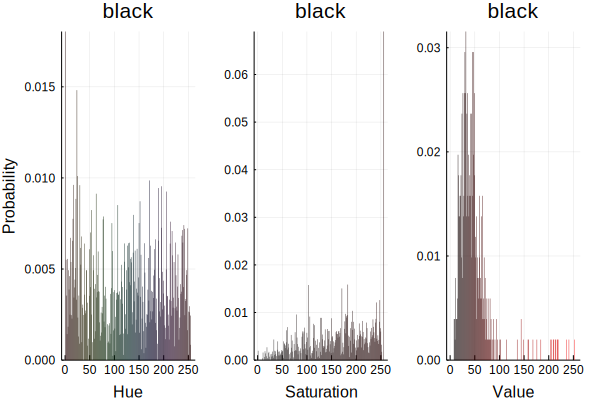

In [8]:
plot_query(oracle_noml_unsmoothed, "black")

In [9]:
ColoringNames.order_relevant_name_pairs(full_data.train)

1-element Array{Array{Any,1},1}:
 Any["light blue-green", "light green-blue"]

In [10]:
38*2

76

In [11]:
ind = findfirst(full_data.dev.texts.=="light blue-green")

50992

In [12]:
full_data.dev.terms_padded[:, ind]

6-element Array{Int64,1}:
  52
 131
   7
 114
   0
   0